In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
import scipy.optimize
import random
import math


# Overview and theory

the task is to implement a svm for classification problem.

the idea is to build a classifier which first makes a transformation of the input data, and then a linear separation where the decision bundary is placed to give maximal margins to the available data points which given by the weights and the bias so the problem is to find the values that maximizes the margin

the larger the margin, the better the generalization

to find the best margin, SVM relied on support vectors, which are the critical training points closest to the decision boundary

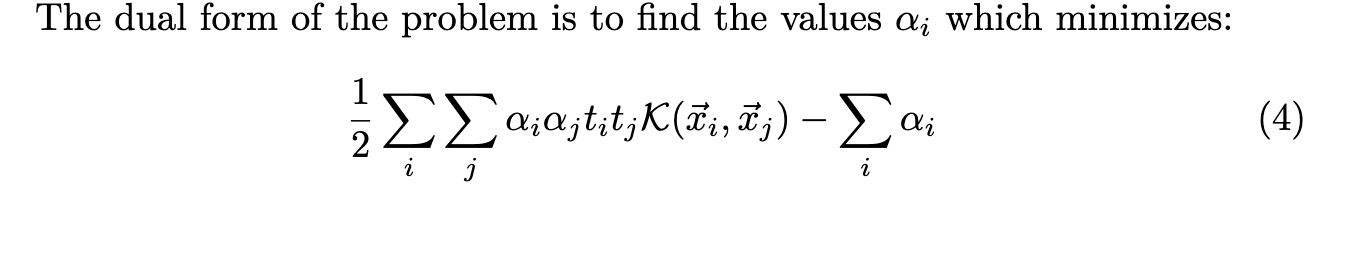

- The optimization ensures:
1. Large-margin classification

2. support vectors are identified natures: the solution will set most ai=0.

3. kernel trick allows nonlinear boundaries

- ∑i​αi​yi​=0 ensures that the decision boundary is properly balanced between both classes.

# Things to implement

## 1. a suitable kernel function

the kernel function takes two data points as inputs and returns a scalar similarity measure

1.1. linear kernel function:

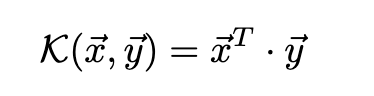

In [3]:
def linear_kernel(x_i, x_j):
    return np.dot(x_i, x_j)

1.2. polynomial kernel function:

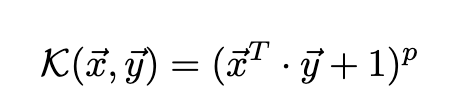

In [4]:
def polynomial_kernel(x_i, x_j, d):
    return (np.dot(x_i, x_j) + 1) ** d

1.3. radial basis function (RBF) kernel:

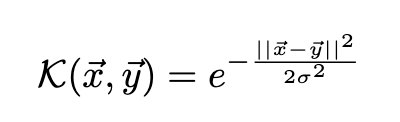

In [5]:
def rbf_kernel(x_i, x_j, sigma):
    return np.exp(-np.linalg.norm(x_i - x_j) ** 2 / (2 * sigma ** 2))

## 2. implement the function objective

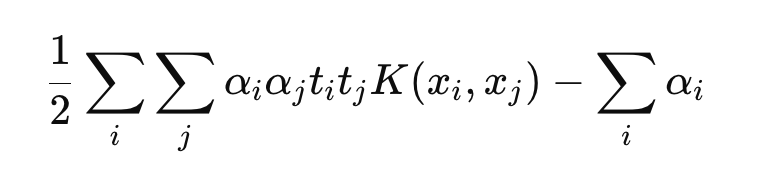

- the first term penalizes large values of αi while enforcing correct separation
- the second term encourages larger values of αi (ensuring some points are selected as support vectors)

2.1. define a function which implements the equation above

- P is a N * N matrix, where each entry represents the similarity between 2 training points xi and xj, weighted by their class labels
- this matrix ensures that points from the same class contribute positively and points from different classes contribute negatively
- so the optimization problem only works with P, avoiding direct dependence on individual samples

- alpha represents the lagrange multipliers used to solve the dual form of the SVM optimization problem

In [17]:
# Define global variables (computed once)
P = np.zeros((N, N))  # This will store the precomputed kernel matrix

def compute_kernel_matrix(x, t, kernel_function):
    """Compute the matrix P_ij = t_i t_j K(x_i, x_j)"""
    global P  # Use a global variable to avoid recomputing it inside objective()
    N = len(t)
    P = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            P[i, j] = t[i] * t[j] * kernel_function(x[i], x[j])

def objective(alpha):
    """Compute the dual SVM objective function"""
    return 0.5 * np.dot(alpha, np.dot(P, alpha)) - np.sum(alpha)


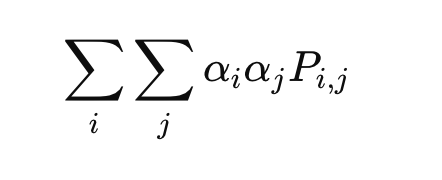

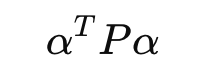

## 3. implement the function zerofun

- zerofun function:
1. the SVM dual optimization problem includes the constraint:

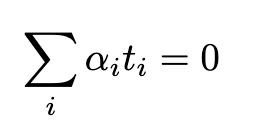

this ensures that the support vectors are properly balanced between the 2 classes

2. the zerofun function will check whether this constraint is satisified

In [7]:
def zerofun(alpha, t):
      """Computes the constraint sum(alpha_i * t_i) = 0."""
      return np.dot(alpha, t)

## 4. call minimize

- the function minimize is used to find the optimal alpha values that satisify:
1. the SVM dual objective function
2. the constraint is 0
3. the bound constraints 0 <= ai <= C

In [34]:
input

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x10fad5410>>

In [36]:
N = len(targets)
C = 1
kernel_function = linear_kernel

t = targets
x = inputs
compute_kernel_matrix(x, t, kernel_function)

In [37]:


start = np.zeros(N) 

# Define bounds (each alpha_i must be between 0 and C)
B = [(0, C) for b in range(N)]



# Call minimize function
ret = scipy.optimize.minimize(objective, start, bounds=B, constraints={'type':'eq', 'fun':lambda alpha: zerofun(alpha, t)})

# Extract the optimized alpha values
alpha = ret['x']

# Check if the optimizer was successful
if ret['success']:
    print("Optimization successful!")
else:
    print("Optimization failed.")


Optimization successful!


## 5. extract the non-zero alpha values

In [38]:
# Threshold to consider values as nonzero
threshold = 1e-5

# Extract nonzero alpha values and corresponding support vectors
support_vectors = [(alpha[i], x[i], t[i]) for i in range(N) if alpha[i] > threshold]

# Print the number of support vectors
print(f"Number of support vectors: {len(support_vectors)}")

Number of support vectors: 11


## 6. calculate the b value 

the bias term b helps position the decision boundary

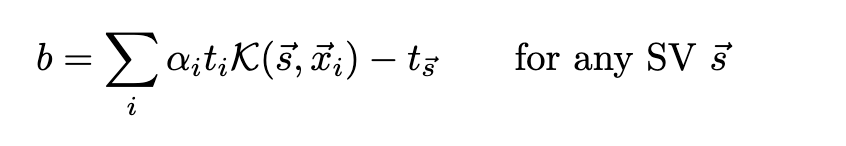

In [39]:
# Select a support vector with 0 < alpha < C
for alpha_i, x_i, t_i in support_vectors:
    if 0 < alpha_i < C:
        b = t_i - sum(alpha_j * t_j * linear_kernel(x_i, x_j) for alpha_j, x_j, t_j in support_vectors)
        break  # Stop after finding one valid support vector

print(f"Computed bias (b): {b}")

Computed bias (b): 0.05347196426431533


## 7. implement the indicator function

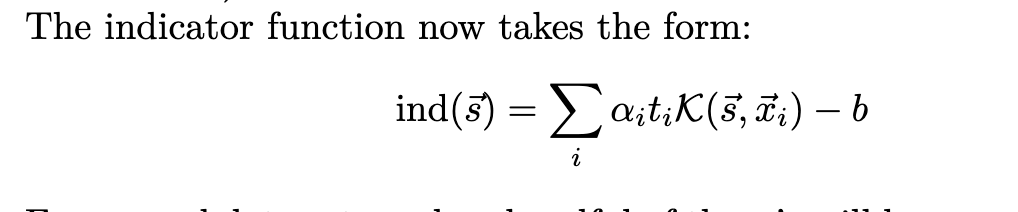

- the indicator function determines which class a new data point belongs to
1. if ind(s) > 0, classify as +1
2. if ind(s) < 0, classify as -1

In [40]:
def indicator(s):
      return sum(alpha_i * t_i * polynomial_kernel(s, x_i, 2) for alpha_i, x_i, t_i in support_vectors) - b

# generating test data

1. generates 2 classes of data (class A and class B):

In [41]:
np.random.seed(100)  

# 2D points normally distributed around (1.5, 0.5) and (-1.5, 0.5)
# the standard deviation is 0.2
classA = np.concatenate(
    (np.random.randn(10, 2) * 0.2 + [1.5, 0.5],   # 10 points around (1.5, 0.5)
     np.random.randn(10, 2) * 0.2 + [-1.5, 0.5])   # 10 points around (-1.5, 0.5)
)
# 20 points normally distributed around (0.0, -0.5)
classB = np.random.randn(20, 2) * 0.2 + [0.0, -0.5]  # 20 points around (0.0, -0.5)



In [42]:
# combine the two classes into one input matrix
inputs = np.concatenate((classA, classB))

In [44]:
# label class A as +1 and class B as -1
targets = np.concatenate(
    (np.ones(classA.shape[0]),  # Class A is labeled +1
     -np.ones(classB.shape[0])) # Class B is labeled -1
)


In [45]:
N = inputs.shape[0]  # Get the total number of points

permute = list(range(N))
random.shuffle(permute)
inputs = inputs[permute, :]  # Shuffle the (x, y) points
targets = targets[permute]   # Shuffle the labels accordingly

In [74]:
N = len(targets)
C = 1
kernel_function = linear_kernel
compute_kernel_matrix(x, t, kernel_function)
t = targets
x = inputs

In [85]:


start = np.zeros(N) 

# Define bounds (each alpha_i must be between 0 and C)
B = [(0, C) for b in range(N)]



# Call minimize function
ret = scipy.optimize.minimize(objective, start, bounds=B, constraints={'type':'eq', 'fun':lambda alpha: zerofun(alpha, t)})

# Extract the optimized alpha values
alpha = ret['x']

# Check if the optimizer was successful
if ret['success']:
    print("Optimization successful!")
else:
    print("Optimization failed.")



Optimization successful!


In [86]:
# Threshold to consider values as nonzero
threshold = 1e-5

# Extract nonzero alpha values and corresponding support vectors
support_vectors = [(alpha[i], x[i], t[i]) for i in range(N) if alpha[i] > threshold]

# Print the number of support vectors
print(f"Number of support vectors: {len(support_vectors)}")

# Select a support vector with 0 < alpha < C
for alpha_i, x_i, t_i in support_vectors:
    if 0 < alpha_i < C:
        b = t_i - sum(alpha_j * t_j * linear_kernel(x_i, x_j) for alpha_j, x_j, t_j in support_vectors)
        break  # Stop after finding one valid support vector

print(f"Computed bias (b): {b}")

def indicator(s):
      return sum(alpha_i * t_i * rbf_kernel(s, x_i, 0.1) for alpha_i, x_i, t_i in support_vectors) - b

Number of support vectors: 11
Computed bias (b): 0.07099265422505496


# plotting

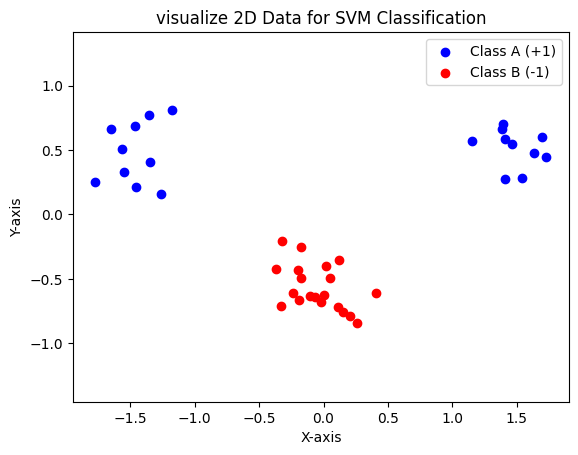

In [63]:
# blue points are class A (+1) and red points are class B (-1)
plt.scatter([p[0] for p in classA],[p[1] for p in classA], color='blue', label='Class A (+1)')
plt.scatter([p[0] for p in classB],[p[1] for p in classB], color='red', label='Class B (-1)')
plt.legend()
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("visualize 2D Data for SVM Classification")
plt.axis('equal')  # Force the same scale on both axes
plt.savefig("svmplot.pdf")
plt.show()

## 1. plotting the decision boundary

In [50]:
xgrid = np.linspace(-5, 5, 50)  # X-values from -5 to 5
ygrid = np.linspace(-4, 4, 50)  # Y-values from -4 to 4

In [51]:
ygrid

array([-4.        , -3.83673469, -3.67346939, -3.51020408, -3.34693878,
       -3.18367347, -3.02040816, -2.85714286, -2.69387755, -2.53061224,
       -2.36734694, -2.20408163, -2.04081633, -1.87755102, -1.71428571,
       -1.55102041, -1.3877551 , -1.2244898 , -1.06122449, -0.89795918,
       -0.73469388, -0.57142857, -0.40816327, -0.24489796, -0.08163265,
        0.08163265,  0.24489796,  0.40816327,  0.57142857,  0.73469388,
        0.89795918,  1.06122449,  1.2244898 ,  1.3877551 ,  1.55102041,
        1.71428571,  1.87755102,  2.04081633,  2.20408163,  2.36734694,
        2.53061224,  2.69387755,  2.85714286,  3.02040816,  3.18367347,
        3.34693878,  3.51020408,  3.67346939,  3.83673469,  4.        ])

In [52]:
grid = np.array([[indicator(np.array([x, y])) for x in xgrid] for y in ygrid])


In [83]:
# Threshold to consider values as nonzero
threshold = 1e-5

# Extract nonzero alpha values and corresponding support vectors
support_vectors = [(alpha[i], x[i], t[i]) for i in range(N) if alpha[i] > threshold]

# Print the number of support vectors
print(f"Number of support vectors: {len(support_vectors)}")

# Select a support vector with 0 < alpha < C
for alpha_i, x_i, t_i in support_vectors:
    if 0 < alpha_i < C:
        b = t_i - sum(alpha_j * t_j * linear_kernel(x_i, x_j) for alpha_j, x_j, t_j in support_vectors)
        break  # Stop after finding one valid support vector

print(f"Computed bias (b): {b}")

def indicator(s):
      return sum(alpha_i * t_i * rbf_kernel(s, x_i, 1.5) for alpha_i, x_i, t_i in support_vectors) - b

Number of support vectors: 11
Computed bias (b): 0.07099265422505496


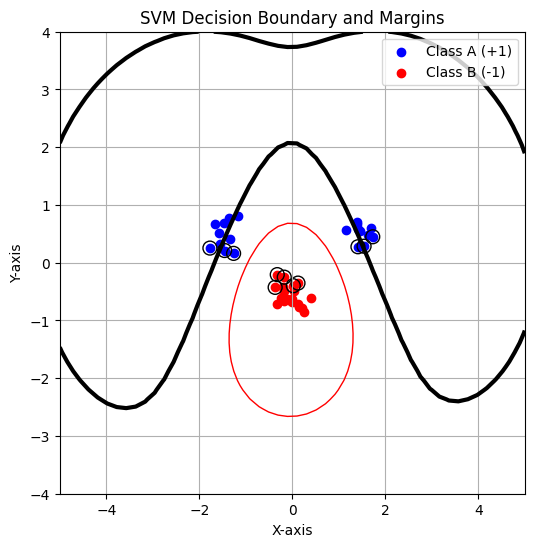

In [84]:
# Generate a grid of points over the input space
xgrid = np.linspace(-5, 5, 50)  # X-range
ygrid = np.linspace(-4, 4, 50)  # Y-range

# Compute the indicator function for each grid point
grid = np.array([[indicator(np.array([x, y])) for x in xgrid] for y in ygrid])

# Plot Decision Boundary and Margins
plt.figure(figsize=(6,6))
plt.contour(xgrid, ygrid, grid, levels=(-1.0, 0.0, 1.0), 
            colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

# Scatter plot of Class A and Class B points
plt.scatter(classA[:, 0], classA[:, 1], color='blue', label="Class A (+1)")
plt.scatter(classB[:, 0], classB[:, 1], color='red', label="Class B (-1)")

# Highlight support vectors with a different marker
for alpha_i, x_i, t_i in support_vectors:
    plt.scatter(x_i[0], x_i[1], s=100, facecolors='none', edgecolors='black')

# Labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("SVM Decision Boundary and Margins")
plt.legend()
plt.grid(True)
plt.show()


# exploring and reporting

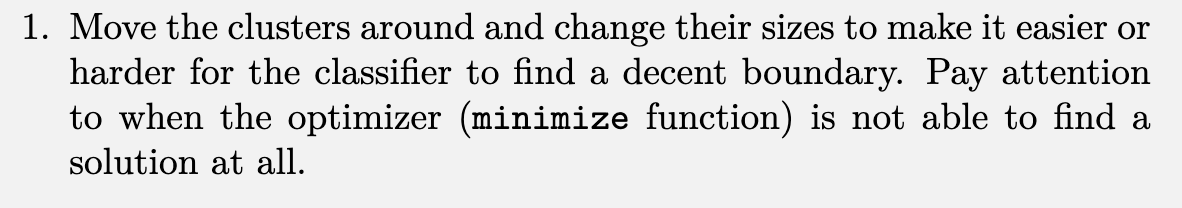

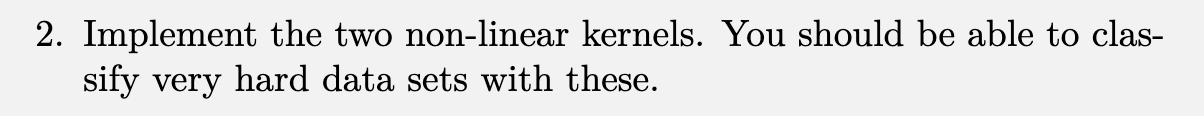

if linear SVM fails, we need non-linear kernels to classifiy the data correctly (which means a straight line cannot divide the classes)
- polynomial kernels allow `curved` decision boundaries

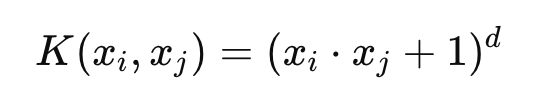

- RBF kernels: when dataset is highly complex (spirals, circles)

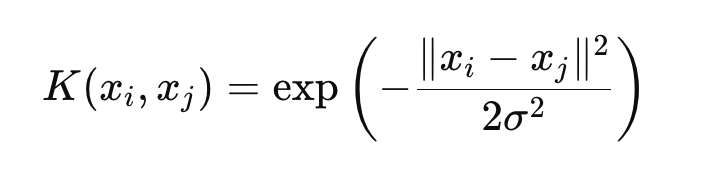

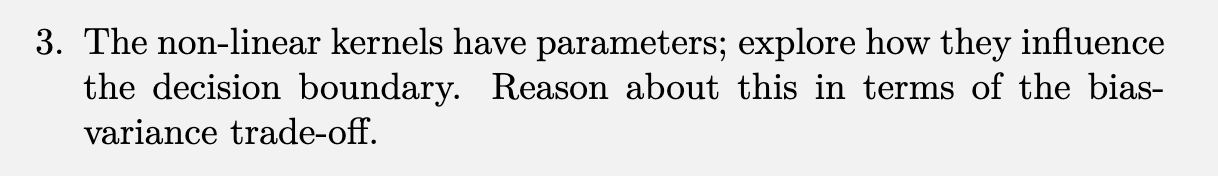

- higher-degree polynomial kernels or small sigma RBF kernels can lead to overfitting 

- bias-variance tradeoff:
1. High bias (underfitting): Large sigma in RBF, low-degree polynomial.
2. High variance (overfitting): Small sigma in RBF, high-degree polynomial.

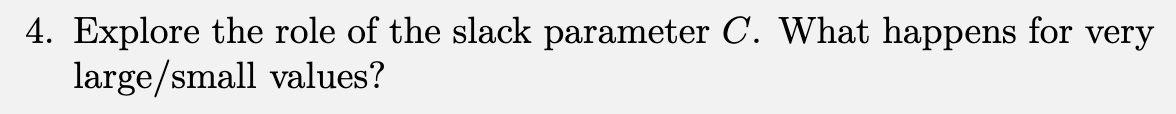

- C controls the trade-off between margin width and classification errors.
1. Higher CC: Narrow margin, fewer misclassifications, but overfits.
2. Lower CC: Wider margin, more misclassifications, but generalizes better.

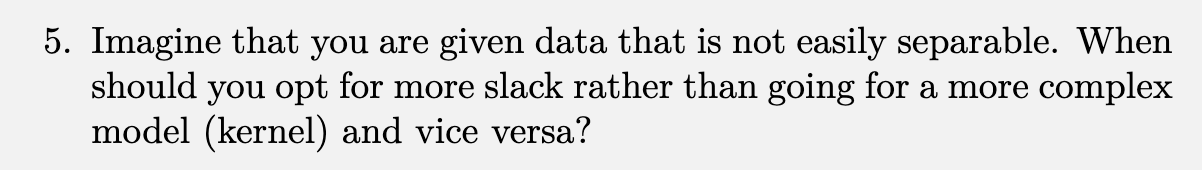

- When to Use More Slack (Lower CC)?

If data is not well-separated but still follows a general trend, try lower CC to allow more flexibility.

- When to Use More Complex Kernels?

If data has clear but non-linear separations, a complex kernel (RBF/Polynomial) is better.

- If noise is present, then use more slack (lower CC).

- If separation is curved, then use a more complex kernel.

1. use the linear kernel to check the different datasets to check the performance of it